In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn import preprocessing 
import os 
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa 
import librosa.display
import tensorflow 
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder 
from scipy.io import wavfile as wav
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset

In [3]:
train_dir = 'Telugu training data/audio'
test_dir = 'Telugu testing data/audio'
train_df = pd.read_excel('Telugu training data/TE-AT-train.xlsx')
test_df = pd.read_excel('Telugu testing data/TE-AT-test.xlsx')
test_df1 = pd.read_csv('Telugu testing data/TE-AT-test_labels.csv')
test_labels = test_df1['Class Label ']

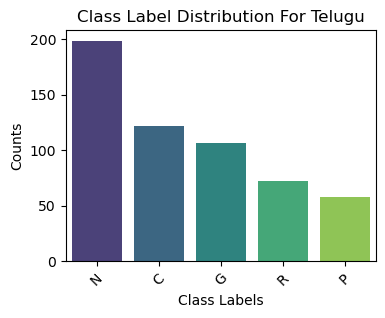

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each class label
label_counts = train_df['Class Label Short'].value_counts()

# Plot the class label counts
plt.figure(figsize=(4, 3))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Class Label Distribution For Telugu')
plt.xlabel('Class Labels')
plt.ylabel('Counts')
plt.xticks(rotation=45)  # Rotate labels for better readability if necessary
plt.show()

In [5]:
train_df['File Name'] = train_df['File_Name'].apply(lambda x: f"{x}.wav" if not x.endswith(".wav") else x)
test_df['File Name'] = test_df['File_Name'].apply(lambda x: f"{x}.wav" if not x.endswith(".wav") else x)

In [6]:
audio_files = os.listdir("Telugu training data/audio")
# Add a column to check if audio exists
train_df["Audio Exists"] = train_df["File_Name"].apply(lambda x: f"{x}.wav" in audio_files) 
# Retain only rows where "Audio Exists" is True
train_df = train_df[train_df["Audio Exists"]]
# Optionally, reset the index if needed
train_df = train_df.reset_index(drop=True)

EXTRACT TEXT FEATURES

In [7]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")
model = AutoModel.from_pretrained("FacebookAI/xlm-roberta-base")
texts = train_df['Transcript'].tolist()
test_text = test_df['Transcript'].tolist()
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=30)
test_input = tokenizer(test_text, padding=True, truncation=True, return_tensors="pt", max_length=30)

c:\Users\nimmi\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
with torch.no_grad():
    text_features = model(**inputs).pooler_output 
    test_features = model(**test_input).pooler_output  # Shape: (batch_size, text_dim)

In [9]:
print(test_features.shape)  #(883, 768)

torch.Size([50, 768])


EXTRACT AUDIO FEATURES

In [10]:
def extract_audio_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)  # Load audio
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Extract MFCCs
    return np.mean(mfccs.T, axis=0)  # Average over time axis

# Extract audio features for all audio files
audio_features = []
audio_test_features = []
for filename in train_df['File Name']:
    audio_path = f"{train_dir}/{filename}"
    audio_features.append(extract_audio_features(audio_path))

for filename in test_df['File Name']:
    audio_path = f"{test_dir}/{filename}"
    audio_test_features.append(extract_audio_features(audio_path))

audio_features = torch.tensor(audio_features, dtype=torch.float32) 
audio_test_features = torch.tensor(audio_test_features, dtype=torch.float32)# Shape: (num_samples, audio_dim)
print(audio_features.shape) 
# print(audio_test_features.shape)  # Example: (num_samples, 13)


torch.Size([551, 13])


C:\Users\nimmi\AppData\Local\Temp\ipykernel_14760\1733730274.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  audio_features = torch.tensor(audio_features, dtype=torch.float32)


In [11]:
from sklearn.preprocessing import StandardScaler
import torch
# Convert to numpy array if needed
audio_features_np = audio_features.numpy() 
audio_test_features_np = audio_test_features.numpy()  # If using PyTorch tensors
scaler = StandardScaler()

# Fit and transform
audio_features_normalized = scaler.fit_transform(audio_features_np)
audio_features_normalized = torch.tensor(audio_features_normalized, dtype=torch.float32)
# Fit and transform
audio_test_features_normalized = scaler.fit_transform(audio_test_features_np)
audio_test_features_normalized = torch.tensor(audio_test_features_normalized, dtype=torch.float32)

# print(audio_features_normalized)

In [12]:
# Ensure both feature sets have the same batch size
combined_features = torch.cat((text_features, audio_features_normalized), dim=1)
combined_test_features = torch.cat((test_features, audio_test_features_normalized), dim=1)  # Shape: (num_samples, text_dim + audio_dim)
# print(combined_features)
# print(combined_features.shape) 
# print(combined_test_features.shape)

In [22]:
# np.save('combined_features.npy', np.array(combined_features))
# np.save('combined_test_features', np.array(combined_test_features))

# combined_features = np.load('combined_features.npy')
# combined_test_features = np.load('combined_test_features.npy')

In [13]:
train_labels = train_df['Class Label Short'] 
classes_list = ["N", "G", "P", "R", "C"] #  N==0(not hate)     hate(G, P, R, C)==1,2,3,4
train_labels = train_labels.apply(classes_list.index)
test_labels = test_labels.apply(classes_list.index)

In [72]:
# Convert to torch tensors
X_train_tensor = torch.tensor(combined_features, dtype=torch.float32)
# X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(combined_test_features, dtype=torch.float32)

y_train_tensor = torch.tensor(train_labels.to_numpy(), dtype=torch.long)
y_test_tensor = torch.tensor(test_labels.to_numpy(), dtype=torch.long)

# y_train_tensor = torch.tensor(y_train, dtype=torch.long)
# y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

C:\Users\nimmi\AppData\Local\Temp\ipykernel_14760\761461807.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(combined_features, dtype=torch.float32)
C:\Users\nimmi\AppData\Local\Temp\ipykernel_14760\761461807.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(combined_test_features, dtype=torch.float32)


MODEL

In [102]:
class MultimodalClassifier(nn.Module):
    def __init__(self, text_dim, audio_dim, hidden_dim, output_dim):
        super(MultimodalClassifier, self).__init__()
        
        # Text subnetwork (deeper architecture)
        self.text_fc = nn.Sequential(
            nn.Linear(text_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.4),  
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            # nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim),  # Additional layer
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.1)
        )
        
        # Audio subnetwork (deeper architecture)
        self.audio_fc = nn.Sequential(
            nn.Linear(audio_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim),  # Additional layer
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.1)
        )
        
        # Fusion and classification (deeper architecture)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),  # Additional layer
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1)  # Use Sigmoid for binary classification
        )
    
    def forward(self, text_features, audio_features):
        # Process text and audio features separately
        text_out = self.text_fc(text_features)
        audio_out = self.audio_fc(audio_features)
        
        # Concatenate features and pass through fusion layers
        combined = torch.cat((text_out, audio_out), dim=1)
        output = self.fc(combined)
        return output


In [103]:
# Function to evaluate the model on validation set
def evaluate_model(model, val_loader, device):
    model.eval()  
    all_preds = []
    all_labels = []   
    with torch.no_grad(): 
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)            
            outputs = model(inputs[:, :text_features.shape[1]], inputs[:, text_features.shape[1]:])            
            _, preds = torch.max(outputs, 1)       
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy()) 
    return all_preds, all_labels

In [128]:
model = MultimodalClassifier(text_dim=text_features.shape[1], 
                             audio_dim=audio_features_normalized.shape[1], 
                             hidden_dim=256, 
                             output_dim=len(classes_list))
                        
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Define loss function and optimizer 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=3e-5)

In [199]:
# Training loop
num_epochs = 149
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)     
        optimizer.zero_grad()  # Zero the gradients      
        # Forward pass
        outputs = model(inputs[:, :text_features.shape[1]], inputs[:, text_features.shape[1]:])      
        # Calculate loss and backpropagate
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()      
        running_loss += loss.item()     
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [200]:
y_pred, y_true = evaluate_model(model, test_loader, device)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro') 
print(f"Accuracy: {accuracy:.4f}") 
print(f"Precision: {precision:.4f}") 
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}") 

Accuracy: 0.2800
Precision: 0.2675
Recall: 0.2800
F1 Score: 0.2610


              precision    recall  f1-score   support

           N       0.50      0.70      0.58        10
           G       0.00      0.00      0.00        10
           P       0.00      0.00      0.00        10
           R       0.33      0.20      0.25        10
           C       0.60      0.60      0.60        10

    accuracy                           0.30        50
   macro avg       0.29      0.30      0.29        50
weighted avg       0.29      0.30      0.29        50



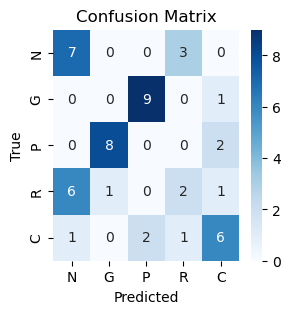

In [194]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=["N", "G", "P", "R", "C"])
print(report)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'G', 'P', 'R', 'C'], yticklabels=['N', 'G', 'P', 'R', 'C'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 

SVM Accuracy: 0.3
              precision    recall  f1-score   support

           N       0.44      0.70      0.54        10
           G       0.00      0.00      0.00        10
           P       0.00      0.00      0.00        10
           R       0.43      0.30      0.35        10
           C       0.83      0.50      0.62        10

    accuracy                           0.30        50
   macro avg       0.34      0.30      0.30        50
weighted avg       0.34      0.30      0.30        50



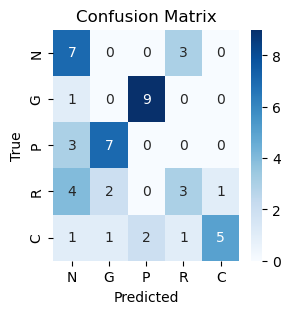

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


# test_labels = test_labels['labels']

# Scale features (important for KNN, SVM)
scaler = StandardScaler()
train_combined_features1 = scaler.fit_transform(combined_features)
test_combined_features1 = scaler.transform(combined_test_features)

# SVM
svm_model = SVC(kernel='rbf', C= 16, gamma= 'auto')
svm_model.fit(train_combined_features1, train_labels)
y_test_svm = svm_model.predict(test_combined_features1)
print("SVM Accuracy:", accuracy_score(test_labels, y_test_svm))
report = classification_report(test_labels, y_test_svm, target_names=['N', 'G', 'P', 'R', 'C'])
print(report)

cm = confusion_matrix(test_labels, y_test_svm)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'G', 'P', 'R', 'C'], yticklabels=['N', 'G', 'P', 'R', 'C'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 

Random Forest Accuracy: 0.28
              precision    recall  f1-score   support

           N       0.23      0.80      0.36        10
           G       0.00      0.00      0.00        10
           P       0.00      0.00      0.00        10
           R       0.33      0.10      0.15        10
           C       0.62      0.50      0.56        10

    accuracy                           0.28        50
   macro avg       0.24      0.28      0.21        50
weighted avg       0.24      0.28      0.21        50



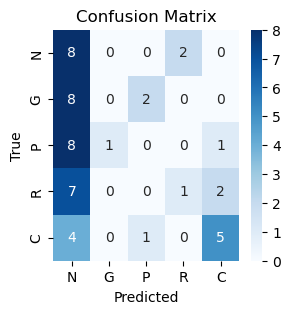

In [122]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest
rf_model = RandomForestClassifier(n_estimators= 200, random_state=100, min_samples_split = 4, min_samples_leaf = 1, criterion = 'gini', max_features = 'sqrt')
rf_model.fit(combined_features, train_labels)
y_pred_rf = rf_model.predict(combined_test_features)
print("Random Forest Accuracy:", accuracy_score(test_labels, y_pred_rf))  
report = classification_report(test_labels, y_pred_rf, target_names=['N', 'G', 'P', 'R', 'C'])
print(report)

cm = confusion_matrix(test_labels, y_pred_rf)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'G', 'P', 'R', 'C'], yticklabels=['N', 'G', 'P', 'R', 'C'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

           N       0.00      0.00      0.00        10
           G       0.14      0.10      0.12        10
           P       0.00      0.00      0.00        10
           R       0.12      0.10      0.11        10
           C       0.54      0.70      0.61        10

    accuracy                           0.18        50
   macro avg       0.16      0.18      0.17        50
weighted avg       0.16      0.18      0.17        50



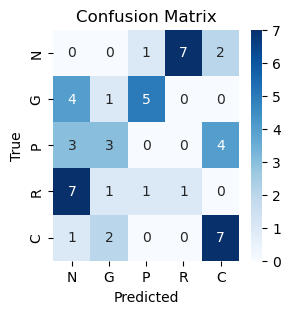

In [124]:
# KNN
knn_model = KNeighborsClassifier(n_neighbors=3, weights = 'uniform', algorithm = 'kd_tree', leaf_size = 2, p=2, metric='minkowski')
knn_model.fit(combined_features, train_labels)
y_pred_knn = knn_model.predict(combined_test_features)
report = classification_report(test_labels, y_pred_knn, target_names=['N', 'G', 'P', 'R', 'C'])
print(report) 

cm = confusion_matrix(test_labels, y_pred_knn)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'G', 'P', 'R', 'C'], yticklabels=['N', 'G', 'P', 'R', 'C'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

           N       0.13      0.30      0.18        10
           G       0.00      0.00      0.00        10
           P       0.00      0.00      0.00        10
           R       0.08      0.10      0.09        10
           C       0.29      0.20      0.24        10

    accuracy                           0.12        50
   macro avg       0.10      0.12      0.10        50
weighted avg       0.10      0.12      0.10        50



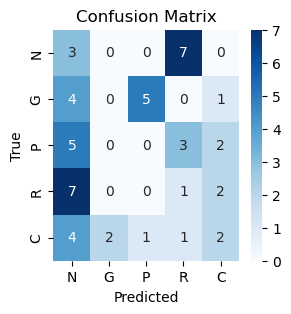

In [32]:
# Naive Bayes (not ideal for embeddings)
nb_model = GaussianNB()
nb_model.fit(combined_features, train_labels)
y_pred_nb = nb_model.predict(combined_test_features)
report = classification_report(test_labels, y_pred_nb, target_names=['N', 'G', 'P', 'R', 'C'])
print(report)

cm = confusion_matrix(test_labels, y_pred_nb)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'G', 'P', 'R', 'C'], yticklabels=['N', 'G', 'P', 'R', 'C'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

           N       0.13      0.20      0.16        10
           G       0.14      0.10      0.12        10
           P       0.00      0.00      0.00        10
           R       0.00      0.00      0.00        10
           C       0.36      0.50      0.42        10

    accuracy                           0.16        50
   macro avg       0.13      0.16      0.14        50
weighted avg       0.13      0.16      0.14        50



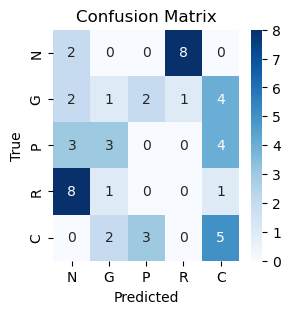

In [125]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=500)

# Train the model
lr_model.fit(combined_features, train_labels)

# Predict using the test data
y_pred_lr = lr_model.predict(combined_test_features)

# Generate the classification report
report = classification_report(test_labels, y_pred_lr, target_names=['N', 'G', 'P', 'R', 'C'])
print(report)

# Confusion matrix
cm = confusion_matrix(test_labels, y_pred_lr)

# Plot the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'G', 'P', 'R', 'C'], yticklabels=['N', 'G', 'P', 'R', 'C'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 

In [281]:
import csv
# df.to_csv("MNLP_task3_Telugu81.63.tsv", sep="\t", quoting=csv.QUOTE_NONE)
# check_submission = pd.read_csv("MNLP_task3_Telugu81.63.tsv", sep="\t") 
# check_submission

,Unnamed: 0,File_Name,Transcript,prediction
0,0,TE_TE_001,ఎస్సీలుగా పుట్టాలని ఎవరు కోరుకుంటారు,G
1,1,TE_TE_002,ఎవరు మాత్రం SC కులంలో పుట్టాలని కోరుకుంటారు అం...,N
2,2,TE_TE_003,హిందువల కోసం కట్టిన పుష్కరఘాట్లో పబ్లిక్ గ మతమ...,R
3,3,TE_TE_004,కొన్ని వందల వేల సంవత్సరాల నుంచి క్రైస్తవులు ప్...,R
4,4,TE_TE_005,ఇందుమూలముగా సో మంచి సంపూర్ణమైన క్యాస్టు సిస్టమ...,N
5,5,TE_TE_006,ఎవరు మాత్రం SC కులంలో పుట్టాలని కోరుకుంటారు,N
6,6,TE_TE_007,ఎవరు మాత్రం SC కులంలో పుట్టాలని కోరుకుంటారు డబ...,N
7,7,TE_TE_008,అందరూ రాజుల కులంలో పుడితే రాజ్యాన్ని ఎలచ్చనుకు...,G
8,8,TE_TE_009,నేను కమ్మోడిని నేను నేన్ పోయి అరె మా అబ్బాయి ప...,N
9,9,TE_TE_010,"కమ్మోలంటే అడుగుతారు కదా గోవేర్నమెంటోళ్లు, ఆ మె...",R
